# **Analysis of Voter Abstention on Brazil's Presidential Elections through Data Clustering**

Dataset link:
https://drive.google.com/file/d/10mr3g08njJv1jVCTdFjNkNO5s51Iqvyv/view?usp=sharing


In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
# I chose to upload the dataset to Google Drive and work with Colab
# If you wont be using Colab, delete this cell and adjust the path on the next one

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/My Drive/justificativa.csv', sep=';')

In [ ]:
# Irrelevant for the analysis
df = df.drop(columns=['Data de carga', 'Município', 'País', 'UF'])

# Possível melhoria - motivo da abstenção ser a distância da UF pra UF de justificativa

In [ ]:
df['Intérprete de libras'] = df['Intérprete de libras'].replace(['N�O INFORMADO', 'N�O'], ['NAO INFORMADO', 'NAO'])
df['Quilombola'] = df['Quilombola'].replace(['N�O INFORMADO', 'N�O'], ['NAO INFORMADO', 'NAO'])
df['Obrigatoriedade do voto'] = df['Obrigatoriedade do voto'].replace('Obrigat�rio', 'Obrigatorio')
df['Identidade de gênero'] = df['Identidade de gênero'].replace(['N�O INFORMADO', 'Cisg�nero', 'Prefere n�o informar',
       'Transg�nero'], ['NAO INFORMADO', 'Cisgenero', 'Prefere nao informar', 'Transgenero'])
df['Raça / cor'] = df['Raça / cor'].replace(['N�O INFORMADO', 'Ind�gena'], ['NAO INFORMADO', 'INDIGENA'])
df['Grau de instrução'] = df['Grau de instrução'].replace(['L� E ESCREVE', 'ENSINO M�DIO COMPLETO', 'ENSINO M�DIO INCOMPLETO', 'N�O INFORMADO'],
 ['LE E ESCREVE', 'ENSINO MEDIO COMPLETO', 'ENSINO MEDIO INCOMPLETO', 'NAO INFORMADO'])
df['Faixa etária'] = df['Faixa etária'].replace('Inv�lida', 'Invalida')
df['Estado civil'] = df['Estado civil'].replace(['N�O INFORMADO', 'VI�VO'], ['NAO INFORMADO', 'VIUVO'])
df['Identidade de gênero'] = df['Identidade de gênero'].replace('N�O INFORMADO', 'NAO INFORMADO')
df['Gênero'] = df['Gênero'].replace('N�O INFORMADO', 'NAO INFORMADO')

In [ ]:
df.head(5)

,Estado civil,Faixa etária,Identidade de gênero,Intérprete de libras,Quilombola,Raça / cor,Região,Ano de eleição,Gênero,Turno,Grau de instrução,Nome social,Obrigatoriedade do voto,Situação do eleitor,UF justificativa,Quantidade de justificativas
0,CASADO,100 anos ou mais,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,CENTRO-OESTE,2024,MASCULINO,1,ANALFABETO,N,Facultativo,Apto,NI,1
1,CASADO,100 anos ou mais,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NORDESTE,2024,FEMININO,1,ENSINO FUNDAMENTAL INCOMPLETO,N,Facultativo,Inapto,NI,1
2,CASADO,100 anos ou mais,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,SUDESTE,2024,MASCULINO,1,LE E ESCREVE,N,Facultativo,Inapto,NI,1
3,CASADO,100 anos ou mais,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,SUDESTE,2024,MASCULINO,1,LE E ESCREVE,N,Facultativo,Apto,NI,1
4,CASADO,100 anos ou mais,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,SUDESTE,2024,FEMININO,1,LE E ESCREVE,N,Facultativo,Inapto,NI,1


In [ ]:
# Treating binary/ternary variables
df['Nome social'] = df['Nome social'].map({'S': 1, 'N': 0})
df['Intérprete de libras'] = df['Intérprete de libras'].map({'SIM': 1, 'NAO': 0, 'NAO INFORMADO': -1})
df['Quilombola'] = df['Quilombola'].map({'SIM': 1, 'NAO': 0, 'NAO INFORMADO': -1})
df['Obrigatoriedade do voto'] = df['Obrigatoriedade do voto'].map({
    'Obrigatorio': 1, 'Facultativo': 0
})
df['Situação do eleitor'] = df['Situação do eleitor'].map({'Apto': 1, 'Inapto': 0})

In [ ]:
df.head(5)

,Estado civil,Faixa etária,Identidade de gênero,Intérprete de libras,Quilombola,Raça / cor,Região,Ano de eleição,Gênero,Turno,Grau de instrução,Nome social,Obrigatoriedade do voto,Situação do eleitor,UF justificativa,Quantidade de justificativas
0,CASADO,100 anos ou mais,NAO INFORMADO,-1,-1,NAO INFORMADO,CENTRO-OESTE,2024,MASCULINO,1,ANALFABETO,0,0,1,NI,1
1,CASADO,100 anos ou mais,NAO INFORMADO,-1,-1,NAO INFORMADO,NORDESTE,2024,FEMININO,1,ENSINO FUNDAMENTAL INCOMPLETO,0,0,0,NI,1
2,CASADO,100 anos ou mais,NAO INFORMADO,-1,-1,NAO INFORMADO,SUDESTE,2024,MASCULINO,1,LE E ESCREVE,0,0,0,NI,1
3,CASADO,100 anos ou mais,NAO INFORMADO,-1,-1,NAO INFORMADO,SUDESTE,2024,MASCULINO,1,LE E ESCREVE,0,0,1,NI,1
4,CASADO,100 anos ou mais,NAO INFORMADO,-1,-1,NAO INFORMADO,SUDESTE,2024,FEMININO,1,LE E ESCREVE,0,0,0,NI,1


In [ ]:
# Age and Education are ordinal, so they must be treated differently
ordinal_cols = ['Faixa etária', 'Grau de instrução']

faixa_etaria_order = [
    '16 anos', '17 anos', '18 anos', '19 anos', '20 anos',
    '21 a 24 anos', '25 a 29 anos', '30 a 34 anos', '35 a 39 anos',
    '40 a 44 anos', '45 a 49 anos', '50 a 54 anos', '55 a 59 anos',
    '60 a 64 anos', '65 a 69 anos', '70 a 74 anos', '75 a 79 anos',
    '80 a 84 anos', '85 a 89 anos', '90 a 94 anos', '95 a 99 anos',
    '100 anos ou mais', 'Invalida'
]

instrucao_order = ['NAO INFORMADO',
                   'ANALFABETO', 'LE E ESCREVE',
                   'ENSINO FUNDAMENTAL INCOMPLETO', 'ENSINO FUNDAMENTAL COMPLETO',
                   'ENSINO MEDIO INCOMPLETO', 'ENSINO MEDIO COMPLETO',
                   'SUPERIOR INCOMPLETO', 'SUPERIOR COMPLETO']

ord_encoder = OrdinalEncoder(categories=[faixa_etaria_order, instrucao_order])

In [ ]:
# These columns have multiple values which must me treated, so I chose to use one-hot encoding
onehot_cols = ['Estado civil', 'Identidade de gênero', 'Raça / cor',
               'Região', 'UF justificativa', 'Gênero']

onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [ ]:
numeric_cols = ['Ano de eleição', 'Turno', 'Quantidade de justificativas']

In [ ]:
# Applies all of the pre-processing steps that were set up
preprocessor = ColumnTransformer(transformers=[
    ('ord', ord_encoder, ordinal_cols),
    ('onehot', onehot_encoder, onehot_cols),
    ('num', StandardScaler(), numeric_cols)
], remainder='passthrough')

In [ ]:
# Applies K-Means
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('clustering', KMeans(n_clusters=4, random_state=42))
])

In [ ]:
# Be aware that the dataset is 400MB long, so the algorithm may take a while to run

X = df.copy()
pipeline.fit(X)
clusters = pipeline.named_steps['clustering'].labels_

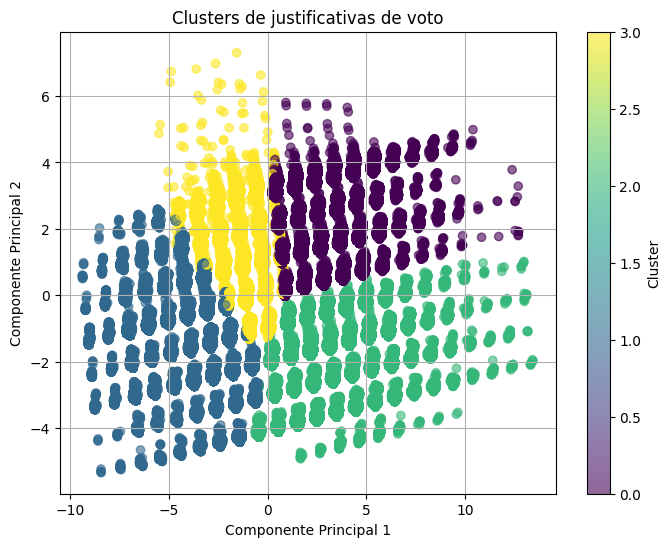

In [ ]:
# Data visualization with PCA
X_preprocessed = pipeline.named_steps['preprocessing'].transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_preprocessed)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title('Clusters de justificativas de voto')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [ ]:
pd.options.display.max_columns = 0

df['Cluster'] = clusters

print("=== MÉDIAS DE ABSTENÇÕES POR CLUSTER ===")
print(df.groupby('Cluster')[['Quantidade de justificativas']].mean())


=== MÉDIAS DE ABSTENÇÕES POR CLUSTER ===
         Quantidade de justificativas
Cluster                              
0                            3.420570
1                            3.426962
2                            2.054735
3                            5.567007


In [ ]:
categorical_cols = ['Faixa etária', 'Grau de instrução', 'Estado civil',
                    'Raça / cor', 'Identidade de gênero', 'Região',
                    'Situação do eleitor', 'Gênero', 'UF justificativa']

for col in categorical_cols:
    print(f"\n=== DISTRIBUIÇÃO DE '{col}' POR CLUSTER ===")
    print(df.groupby('Cluster')[col].value_counts(normalize=True).rename("Proporção").mul(100).round(1))



=== DISTRIBUIÇÃO DE 'Faixa etária' POR CLUSTER ===
Cluster  Faixa etária    
0        45 a 49 anos        26.3
         50 a 54 anos        21.2
         55 a 59 anos        18.5
         60 a 64 anos        16.2
         65 a 69 anos        12.3
         70 a 74 anos         3.9
         75 a 79 anos         1.2
         80 a 84 anos         0.3
         85 a 89 anos         0.1
         90 a 94 anos         0.0
         95 a 99 anos         0.0
         Invalida             0.0
         100 anos ou mais     0.0
1        25 a 29 anos        27.6
         21 a 24 anos        22.4
         30 a 34 anos        18.0
         35 a 39 anos        10.2
         20 anos              8.2
         19 anos              7.3
         18 anos              5.0
         17 anos              0.9
         16 anos              0.4
2        45 a 49 anos        17.7
         50 a 54 anos        17.1
         55 a 59 anos        17.0
         60 a 64 anos        15.5
         40 a 44 anos        13.1
    